# <center><u> XGBoost

In [2]:
#Import Libraries and Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
#Access Credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [4]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [5]:
query="""
    select * 
    from agg.tidy_data_final
    where site = 20
"""

In [6]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_55306/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [7]:
df = df.set_index('timestamp', drop=False)
df = df.sort_index()

# Prepare Data Set for LSTM/GRU Models

In [8]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 24
# 2 hours = 2 * 2 = 8 

n_input = 144
n_features = 14 #These includes the weather predictions that will be added later on and the normalised varaibles to be created
n_output = 72


# Selectfeatures of use for later on
df_input = df[['net_load', 'year', 'month', 'day', 'hour', 'day_of_week', 'season','precipitation_probability',
               'solar_radiation','sunshine_duration','weekend_or_bank_holiday','avg_net_load']]

# Normalise Data (as seen in Literature)

Group decision to use MaxAbs Scaler to normalise the data.

In [9]:
#Normalise all continuous variables needing scaling
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

variables = ['net_load','solar_radiation','sunshine_duration','avg_net_load']
for var in variables:
    new_var_name = var + '_norm'
    df_input[new_var_name] = scaler.fit_transform(df_input[[var]])

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_55306/4282254998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_55306/4282254998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_55306/4282254998.py:8: SettingWithCopyWarning: 
A value is trying to be

Now, we also want to include the predictions for 'solar radiation', 'sunshine_duration', 'precipitation_probability' as inputs.
These will be treated as new inputs (t+48) ~ 48 half-hourly timestamps representing day-ahead predictions.

In [9]:
df_input['sunshine_duration(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
df_input['solar_radiation(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
df_input['precipitation_probability(t+48)'] = df_input['precipitation_probability'].shift(-48) #Add prediction for time the day after

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_40500/3763762080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['sunshine_duration(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_40500/3763762080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['solar_radiation(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
/var/folders/n

In [10]:
#We want to drop last 48 rows as they will have Na values for the (t+48) columns/inputs.
df_input.dropna(inplace=True)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_55306/1212278532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.dropna(inplace=True)


In [11]:
#Only Keep the Normalised Variables for the Model
df_input = df_input[['net_load_norm','month','day','hour','day_of_week','season','weekend_or_bank_holiday',
               'solar_radiation_norm','sunshine_duration_norm','precipitation_probability']]

# Generate X and Y Matrices

In [12]:
X, y = [], []
for i in range(len(df_input) - n_input - n_output + 1):
    # Select all columns for the input sequence
    X.append(df_input.iloc[i:(i + n_input)].values)  
    
    y.append(df_input['net_load_norm'].iloc[(i + n_input):(i + n_input + n_output)].values)

X = np.array(X).reshape((len(X), n_input, -1))  
y = np.array(y)

# Train and Test Split

In [13]:
# Split into train (First ~330 days) and test (30 days)
# 1 time step = 30 mins

n_total_days = len(X) / (2 * 24)
n_test_days = 30
n_train_split = int((n_total_days - n_test_days) * 2 * 24)

X_train = X[:n_train_split]
y_train = y[:n_train_split]

X_test = X[n_train_split:]
y_test = y[n_train_split:]

## GRU Model

In [18]:
model5 = Sequential()
model5.add(GRU(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))
model5.add(GRU(128, activation='relu', return_sequences=True))
model5.add(BatchNormalization())
model5.add(GRU(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))
model5.add(Dense(y_train.shape[1]))

# XGBoost

In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

n_total_days = len(X) / (2 * 24)
n_test_days = 30
n_train_split = int((n_total_days - n_test_days) * 2 * 24)

X_train = X[:n_train_split]
y_train = y[:n_train_split]

X_test = X[n_train_split:]
y_test = y[n_train_split:]


X = df_input.drop(columns=['net_load_norm'])
y = df_input['net_load_norm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Step 4: Train XGBoost Model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Step 5: Feature Importance Calculation
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, you can evaluate the XGBoost model on your test data
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

                     Feature  Importance
6       solar_radiation_norm    0.504696
0                      month    0.128163
2                       hour    0.100087
7     sunshine_duration_norm    0.074735
8  precipitation_probability    0.051358
1                        day    0.045052
3                day_of_week    0.043747
4                     season    0.031901
5    weekend_or_bank_holiday    0.020260
Mean Squared Error on Test Set: 0.025293682793108497


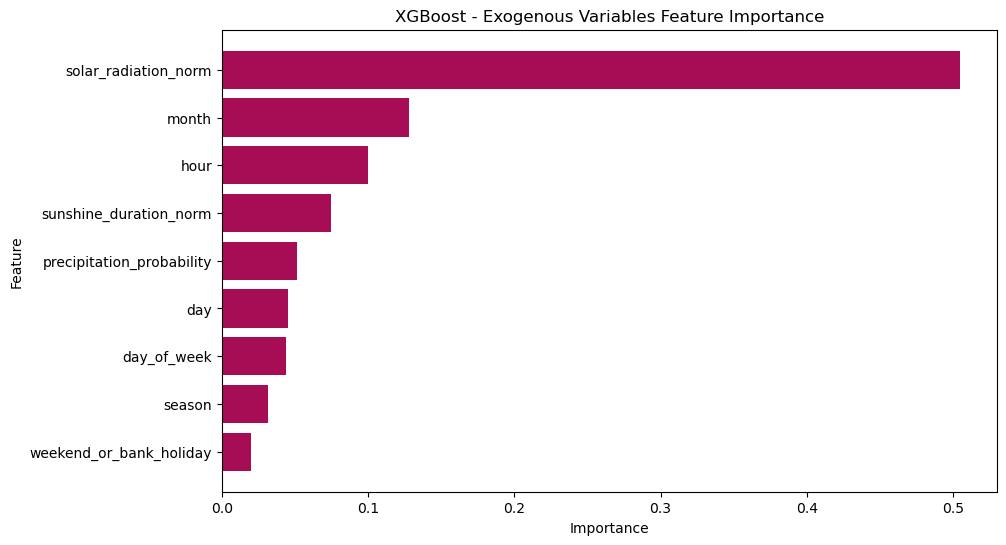

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#A70D55')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost - Exogenous Variables Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()